In [1]:
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory

# Approach 1.Pyomo with GLPK

In [2]:
# read data from xlsx file
data = pd.read_excel(open('GB730 Final Project - Knapsack Problem.xlsx','rb'), sheet_name='data')
cost=data["COGS($)"]
profit=data["Profit($)"]
item=data["SKU"]
budget=20000

In [3]:
# Declare a concrete model
model=ConcreteModel()
num_item=len(item) #possible dc locations (columns) index them by i
# declare the decision variables
model.x=Var(range(num_item),domain=Binary) 
#constraint: cost meets budget limit
model.Constraint=Constraint(expr=sum(model.x[i]*cost[i] for i in range(num_item))<=budget)
#objective: max total profit
model.Objective=Objective(expr=sum(model.x[i]*profit[i] for i in range(num_item)),sense=maximize)
opt=SolverFactory('glpk')
opt.options['mipgap']=0
results=opt.solve(model,tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --mipgap 0 --write C:\Users\49680\AppData\Local\Temp\tmpvzmb4fbz.glpk.raw
 --wglp C:\Users\49680\AppData\Local\Temp\tmpaiph4tix.glpk.glp --cpxlp C:\Users\49680\AppData\Local\Temp\tmpqdhii0z3.pyomo.lp
Reading problem data from 'C:\Users\49680\AppData\Local\Temp\tmpqdhii0z3.pyomo.lp'...
C:\Users\49680\AppData\Local\Temp\tmpqdhii0z3.pyomo.lp:1516: warning: lower bound of variable 'x1' redefined
C:\Users\49680\AppData\Local\Temp\tmpqdhii0z3.pyomo.lp:1516: warning: upper bound of variable 'x1' redefined
2 rows, 501 columns, 501 non-zeros
500 integer variables, all of which are binary
2016 lines were read
Writing problem data to 'C:\Users\49680\AppData\Local\Temp\tmpaiph4tix.glpk.glp'...
1510 lines were written
GLPK Integer Optimizer 5.0
2 rows, 501 columns, 501 non-zeros
500 integer variables, all of which are binary
Preprocessing...
1 row, 500 columns, 500 non-zeros
500 integer variables, all of which are binary
Sc

In [4]:
#printing solution
print("Obj: Total Profit",model.Objective())

Obj: Total Profit 25745.0


In [5]:
#printing selected items
selection=[]
for i in range(num_item):
    if model.x[i]()==1:
        selection.append(item[i])
selection
solution=[]
for i in range(num_item):
    solution.append(model.x[i]())
#print(solution)
data["solution"]=solution
data.head()
#data.to_csv('test.csv',index=False)
print("Select:",str(selection)[1:-1] )

Select: 2, 10, 11, 13, 14, 26, 35, 36, 39, 49, 61, 69, 79, 82, 83, 84, 86, 89, 106, 107, 111, 116, 122, 126, 128, 129, 135, 142, 145, 147, 155, 174, 176, 178, 190, 205, 208, 217, 227, 233, 238, 239, 240, 243, 252, 272, 274, 282, 286, 287, 288, 304, 309, 314, 315, 332, 335, 337, 346, 348, 350, 357, 363, 365, 381, 383, 386, 391, 396, 401, 403, 405, 407, 420, 426, 428, 429, 430, 434, 441, 460, 463, 466, 475, 477, 482, 493, 495, 496, 497, 498


# Approach 2.Google OR-Tools

In [6]:
from ortools.algorithms import pywrapknapsack_solver

In [7]:
# read data from xlsx file
data = pd.read_excel(open('GB730 Final Project - Knapsack Problem.xlsx','rb'), sheet_name='data')
cost=data["COGS($)"]
profit=data["Profit($)"]
item=data["SKU"]
budget=20000

In [8]:
def main():
    # Create the solver.
    solver = pywrapknapsack_solver.KnapsackSolver(
        pywrapknapsack_solver.KnapsackSolver.
        KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER, 'KnapsackExample') 

    values=list(profit)
    weights=[list(cost)]
    capacities=[20000]
    
    solver.Init(values, weights, capacities)
    computed_value = solver.Solve()
    
    packed_items = []
    packed_cost = []
    total_cost = 0
    print('Total profit =', computed_value)
    for i in range(len(profit)):
        if solver.BestSolutionContains(i):
            packed_items.append(i+1)
            packed_cost.append(weights[0][i])
            total_cost += weights[0][i]
    print('Total cost:', total_cost)
    print('Packed items:', packed_items)
    print('Packed_cost:', packed_cost)


if __name__ == '__main__':
    main()

Total profit = 25745
Total cost: 20000
Packed items: [2, 10, 11, 13, 14, 26, 35, 36, 39, 49, 61, 69, 79, 82, 83, 84, 86, 89, 106, 107, 111, 116, 122, 126, 128, 129, 135, 142, 145, 147, 155, 174, 176, 178, 190, 205, 208, 217, 227, 233, 238, 239, 240, 243, 252, 272, 274, 282, 286, 287, 288, 304, 309, 314, 315, 332, 335, 337, 346, 348, 350, 357, 363, 365, 381, 383, 386, 391, 396, 401, 403, 405, 407, 420, 426, 428, 429, 430, 434, 441, 460, 463, 466, 475, 477, 482, 493, 495, 496, 497, 498]
Packed_cost: [257, 160, 1, 40, 58, 97, 144, 48, 35, 1, 64, 626, 220, 563, 56, 157, 537, 124, 651, 595, 338, 64, 1, 273, 450, 174, 1, 286, 103, 1, 195, 90, 214, 228, 92, 530, 343, 1, 349, 271, 254, 277, 100, 535, 613, 217, 1, 1, 340, 503, 1, 59, 122, 395, 250, 57, 1, 415, 444, 12, 81, 635, 14, 241, 468, 1, 274, 137, 160, 423, 216, 271, 243, 1, 147, 91, 431, 606, 222, 44, 264, 131, 197, 321, 19, 277, 259, 1, 421, 270, 99]


# Visualization

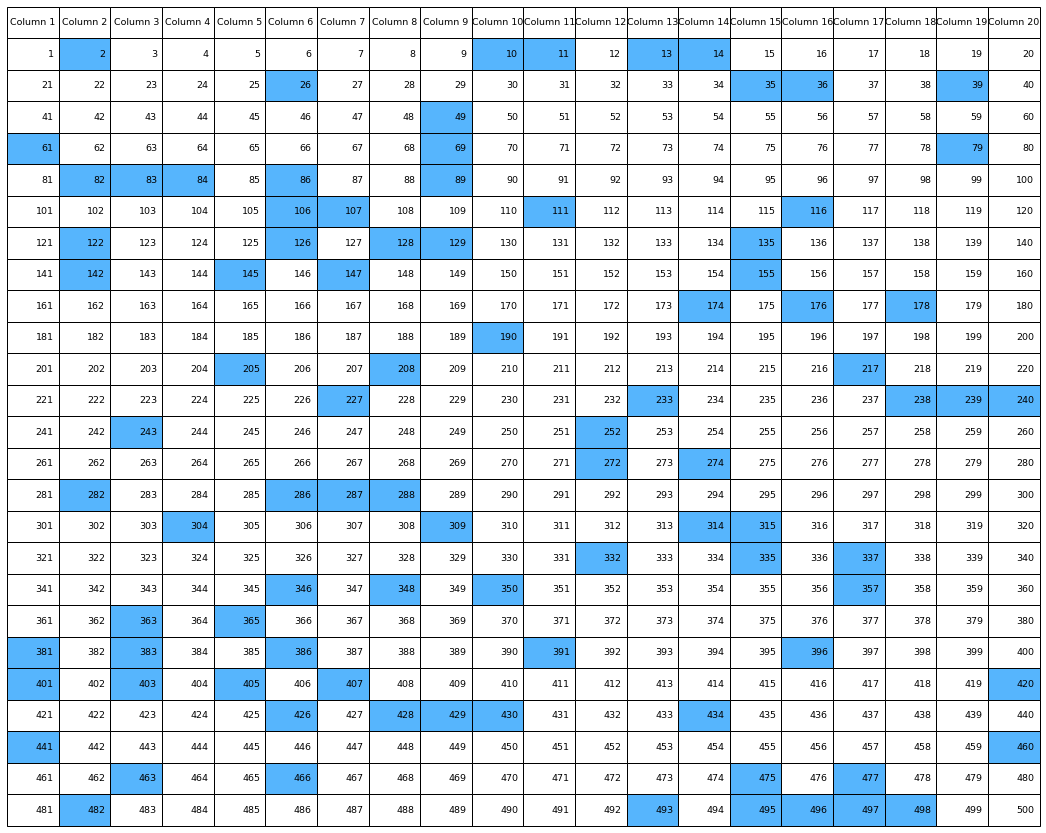

In [9]:
import matplotlib.pyplot as plt

itemlist=[[]] * 25
for i in range(0,25):
    itemlist[i]=list(range(1+20*i, 21+20*i))


fig, ax =plt.subplots(1,1)
column_labels=[]
for j in range(1,26):
    column_labels.append("Column "+str(j))
    
colors = [[]] * 25
for k in range(0,25):
    colors[k]=[]
    for m in range(0,20):
        if itemlist[k][m] in selection:
            colors[k].append("#56b5fd")
        else:
            colors[k].append("w")

ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=itemlist,colLabels=column_labels,loc="center",cellColours=colors,fontsize=30)
the_table.auto_set_font_size(False)
the_table.set_fontsize(9.5)
fig.set_size_inches(18.5, 10.5)
plt.show()